# Loading Libraries

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Load and transform CIFAR10 dataset

In [2]:
def create_data_loaders(batch_size):
    # Standard CIFAR10 transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainset, trainloader, testset, testloader

In [3]:
trainset, trainloader, testset, testloader = create_data_loaders(64)

Files already downloaded and verified
Files already downloaded and verified


# General Functions

## Visualization

In [4]:
def display_filters(weights, filename):
    N = int(np.ceil(np.sqrt(weights.shape[0])))
    f, axarr = plt.subplots(N, N, figsize=(12, 12))
    scaled = (weights - weights.min()) / (weights.max() - weights.min())  # Scale the weights for better plotting

    p = 0
    for i in range(N):
        for j in range(N):
            # Empty plot white when out of kernels to display
            if p >= scaled.shape[0]:
                krnl = torch.ones((scaled.shape[2], scaled.shape[3], 3))
            else:
                if scaled.shape[1] == 1:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl, cmap="gray")
                elif scaled.shape[1] == 3:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl)
                else:
                    krnl = scaled[p, 0, :, :]
                    axarr[i, j].imshow(krnl, cmap="gray")
            axarr[i, j].axis("off")
            p += 1

    # Save the figure
    plt.savefig(filename)

    # Show the plot
    plt.show()

# CustomCNN

## Define the CustomCNN

In [5]:
# Custom CNN Architecture with Batch Normalization, and Dropout options
class CustomCNN(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False):
        super(CustomCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the size according to your input image dimensions
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x) if self.use_batch_norm else x
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.use_batch_norm else x
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x) if self.use_dropout else x

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x) if self.use_batch_norm else x
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x) if self.use_batch_norm else x
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x) if self.use_dropout else x

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x) if self.use_batch_norm else x
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x) if self.use_batch_norm else x
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x) if self.use_dropout else x

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x) if self.use_dropout else x
        x = self.fc2(x)

        return x

## Instantiate the CustomCNN model

In [6]:
network = CustomCNN(use_batch_norm=True, use_dropout=True)

### Load custom_cnn_model_best_task2 model weights from Task 2

In [7]:
model_path = "custom_cnn_model_best_task2.pth"
network.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
network.eval()

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel

## Apply the Visualization to Convolutional Layers of CustomCNN

Filters of Conv Layer 1:


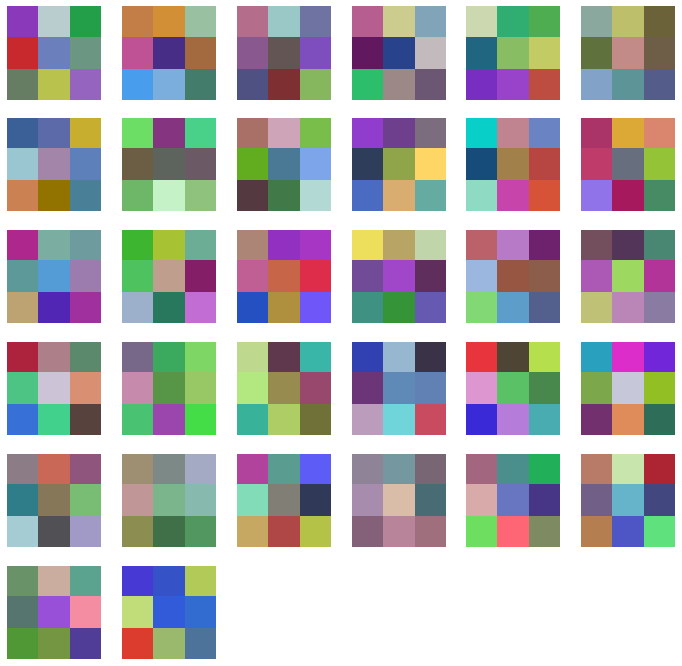

Filters of Conv Layer 2:


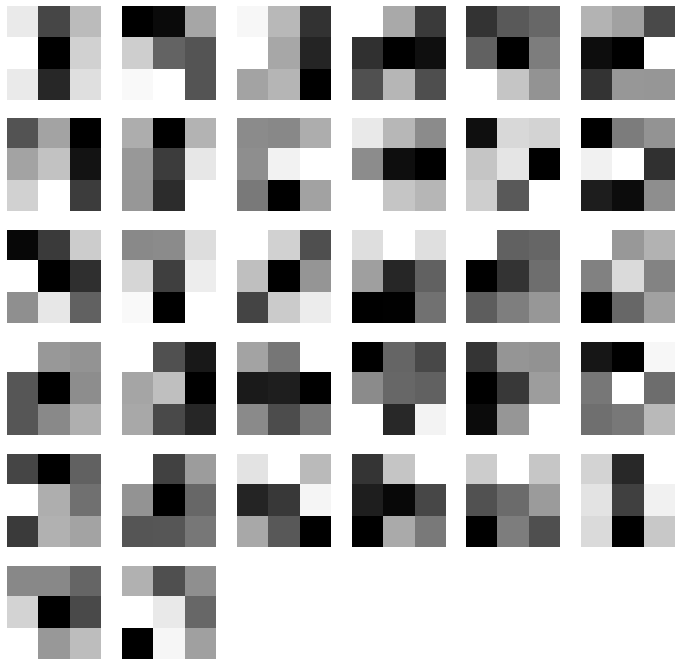

Filters of Conv Layer 3:


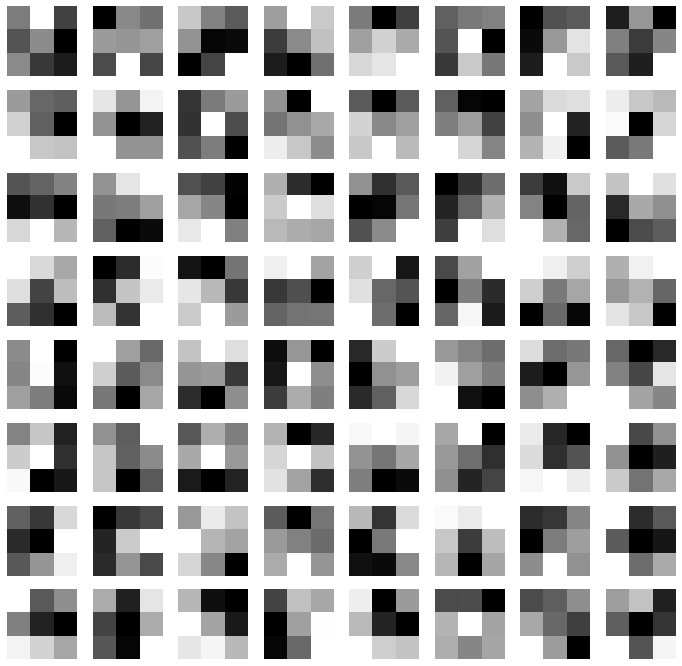

Filters of Conv Layer 4:


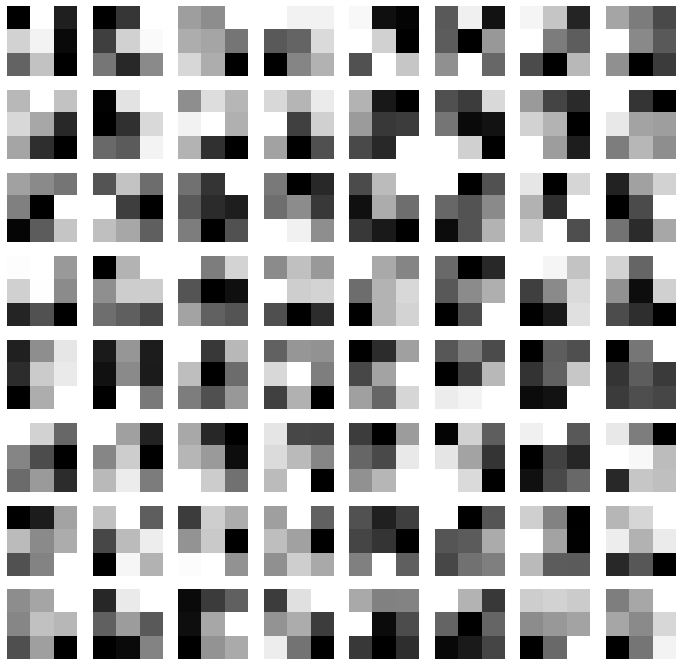

Filters of Conv Layer 5:


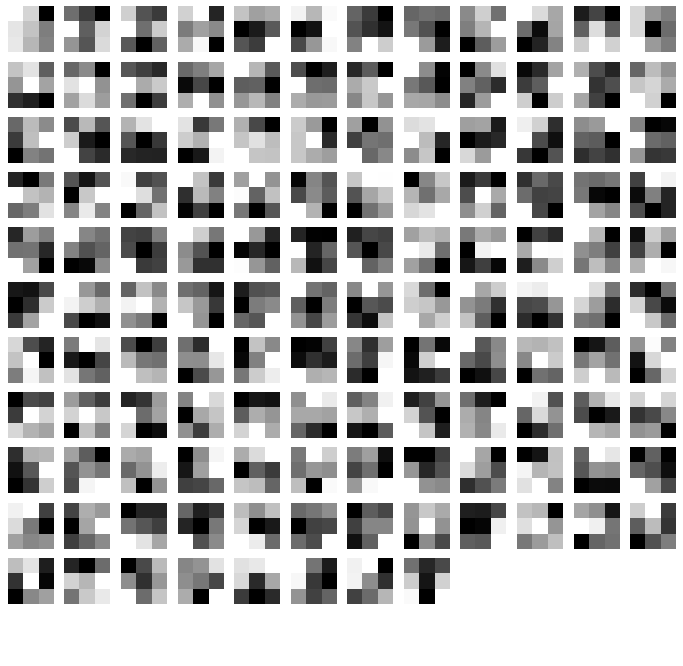

Filters of Conv Layer 6:


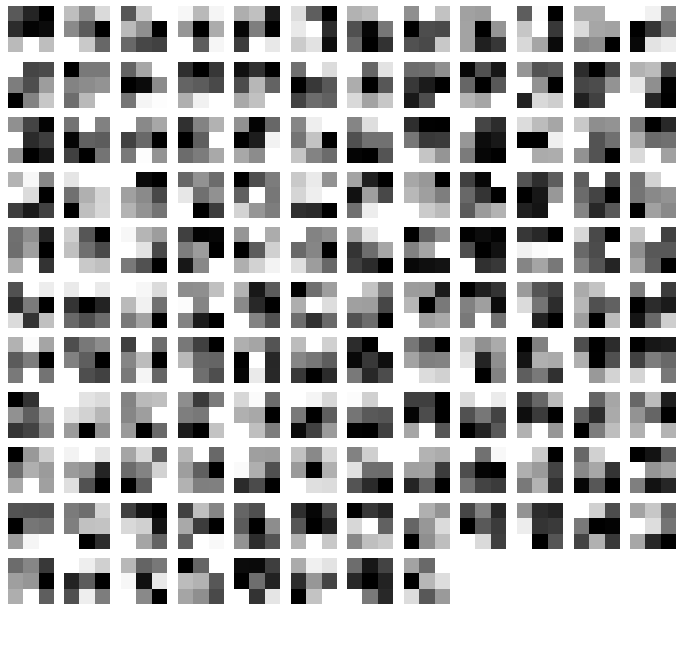

In [8]:
conv_layers = [network.conv1, network.conv2, network.conv3, network.conv4, network.conv5, network.conv6]

for i, conv_layer in enumerate(conv_layers):
    print(f"Filters of Conv Layer {i+1}:")
    filters = conv_layer.weight.data.clone().cpu()
    filename = f"conv_layer_{i+1}_filters.png"  # Filename for saving the figure
    display_filters(filters, filename)

## Creating an Extractor Model for the CustomCNN model

In [9]:
class ActivationExtractor(nn.Module):
    def __init__(self, original_model):
        super(ActivationExtractor, self).__init__()
        # Copy layers from the original model up to the flatten layer
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu1,
            original_model.conv2,
            original_model.bn2,
            original_model.relu2,
            original_model.pool1,
            original_model.dropout1,
            original_model.conv3,
            original_model.bn3,
            original_model.relu3,
            original_model.conv4,
            original_model.bn4,
            original_model.relu4,
            original_model.pool2,
            original_model.dropout2,
            original_model.conv5,
            original_model.bn5,
            original_model.relu5,
            original_model.conv6,
            original_model.bn6,
            original_model.relu6,
            original_model.pool3,
            original_model.dropout3,
            original_model.flatten
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [11]:
# Initialize the extractor model
extractor = ActivationExtractor(network)
# Ensure the extractor model is on the same device as the inputs
extractor.to('cuda' if torch.cuda.is_available() else 'cpu')
extractor

ActivationExtractor(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): 

## Extracting Activations

In [14]:
# Disable gradients computation
torch.set_grad_enabled(False);

In [15]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
activations = []
for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    # Detach the output from the computation graph before converting to numpy
    extracted_features = extractor(inputs).cpu().numpy()
    activations.append(extracted_features)

activations = np.concatenate(activations)

# Check the shape of the extracted features
print("Shape of extracted activations:", activations.shape)

Shape of extracted activations: (10000, 2048)


## Finding per unit top K samples

In [19]:
testimages = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

K = 10  # Number of top activations to retrieve
idxs_top10 = np.argsort(activations, axis=0)[::-1][0:K, :]

Files already downloaded and verified


In [31]:
idxs_top10.shape

(10, 2048)

In [32]:
# Initialize an array to store the picked samples
#picked_samples = np.zeros((K, n_units, 32, 32, 3), dtype=float)
picked_samples = np.zeros((K, idxs_top10.shape[1], 32, 32, 3), dtype=float)

for i in range(idxs_top10.shape[0]):
    for j in range(idxs_top10.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10[i, j]][0]) / 255.0
        picked_samples[i, j, :, :, :] = img_as_np

# Check the shape of picked_samples
print("Shape of picked_samples:", picked_samples.shape)
# The shape of the tensor corresponds to:
# (n_images,n_units,nb_rows,nb_cols,nb_channels)
# for each of the 2048 units in the layers, we have 10 images

Shape of picked_samples: (10, 2048, 32, 32, 3)


In [38]:
# Visualization function with unnormalization and saving the figure
def vis_topk(ims, units, filename="top_k_activations.png"):
    f, axarr = plt.subplots(ims.shape[0], ims.shape[1], figsize=(16, 12))

    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):
            axarr[i, j].imshow(ims[i, j, :, :, :])
            axarr[i, j].axis('off')
            if i == 0:  # Only set the title for the top row
                axarr[i, j].set_title('Unit ' + str(units[j]))

    # Adjust layout
    plt.tight_layout()
    # Save the figure
    plt.savefig(filename)
    # Show the plot
    plt.show()

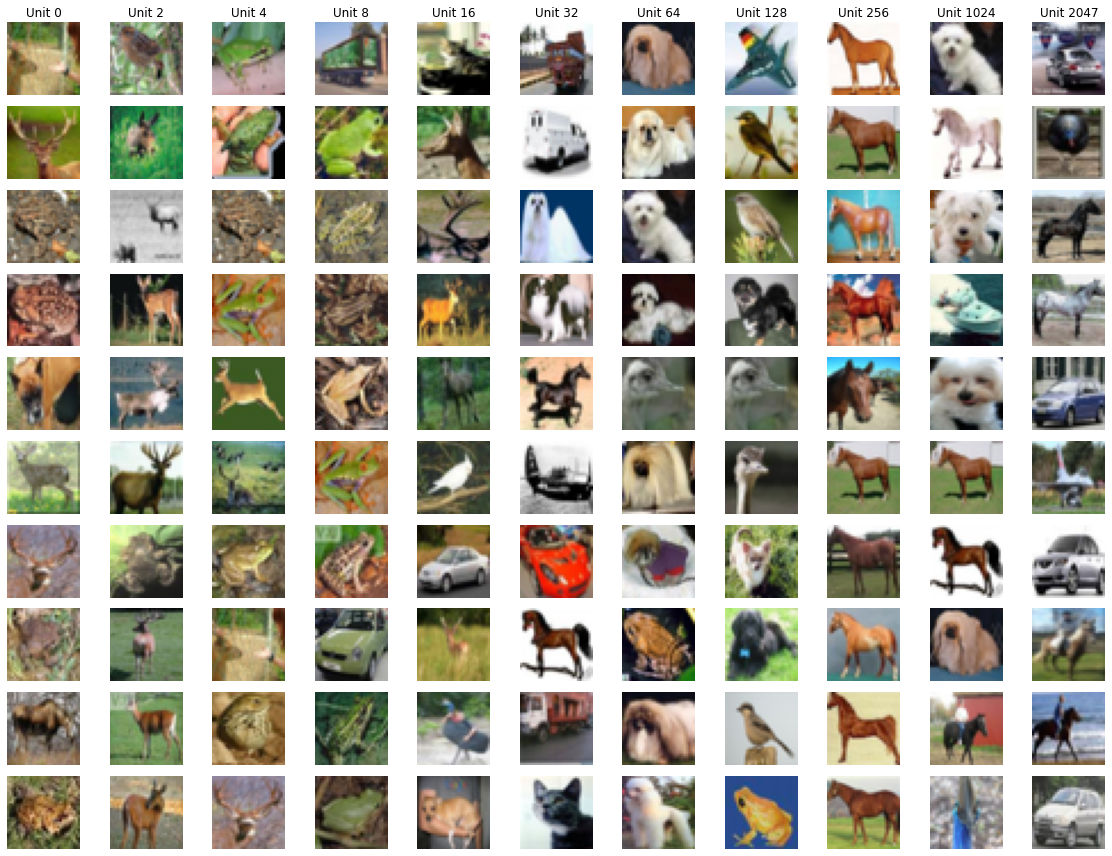

In [39]:
units = [0, 2, 4, 8, 16, 32, 64, 128, 256, 1024, 2047]  # Specified units
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples[:, units, :, :].squeeze()

vis_topk(ims, units, "top_k_activations_custom_cnn.png")

## Show t-SNE plot on each of the Dense/Linear/Fully Connected layer.

In [47]:
def plot_tsne(activations_tsne, labels, title='t-SNE visualization', figsize=(10, 8), point_size=20, cmap='jet', filename='dense_layer_tsne.png'):
    num_classes = len(np.unique(labels))
    cifar_labels = [str(i) for i in range(num_classes)]
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=labels, cmap=plt.get_cmap(cmap, num_classes), s=point_size, alpha=0.6)
    plt.clim(-0.5, num_classes - 0.5)
    cbar = plt.colorbar(scatter, ticks=range(num_classes))
    cbar.ax.set_yticklabels(cifar_labels)
    plt.title(title)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.grid(True)

    # Save the figure
    plt.savefig(filename)
    
    # Show the plot
    plt.show()

In [48]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer
n_components_pca = 50  # Number of components to keep for PCA
pca = PCA(n_components=n_components_pca)
activations_reduced = pca.fit_transform(activations)

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 2000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_tsne = tsne.fit_transform(activations_reduced)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_tsne.shape)

/home/odykypar/miniconda3/envs/aml-block3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/odykypar/miniconda3/envs/aml-block3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 41.51 seconds
Shape of t-SNE 2D features: (10000, 2)


In [49]:
# Retrieve the labels for test dataset
labels = [y for _, y in testset]

# Plotting the t-SNE results
cifar_labels = [str(i) for i in range(10)]  # Assuming labels are from 0 to 9
s = 40  # Area of samples; increase if you don't see clear colors

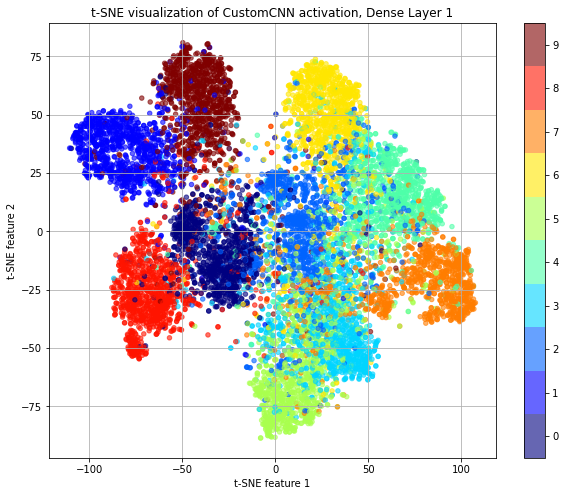

In [51]:
# Usage:
plot_tsne(activations_tsne, labels, title="t-SNE visualization of CustomCNN activation, Dense Layer 1")

# VGG16

# Instantiate a pre-trained VGG16 model

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# Set the model to evaluation mode
vgg16.eval()

### Apply the Visualization to Convolutional Layers of VGG16

In [ ]:
# Iterate over the features module of VGG16
for i, layer in enumerate(vgg16.features):
    if isinstance(layer, nn.Conv2d):
        print(f"Filters of Conv Layer {i}:")
        filters = layer.weight.data.clone().cpu()
        filename = f"vgg16_conv_layer_{i}_filters.png"  # Filename for saving the figure
        display_filters(filters, filename)